In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

arifkaggle979_cyberbullying_path = kagglehub.dataset_download('arifkaggle979/cyberbullying')

print('Data source import complete.')


# CNN+LSTM

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, Dropout, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load and preprocess dataset (correctly reading the Excel file)
data_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(data_path)

# Display data overview
print(data.head())

# Preprocessing
def preprocess_text(data):
    # Removing special characters, stopwords, etc.
    stopwords = set("অতএব অথচ অথবা".split())  # Add actual stopwords list
    data['cleaned_comment'] = data['comment'].str.replace(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', regex=True)
    data['cleaned_comment'] = data['cleaned_comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
    return data

# Apply preprocessing
data = preprocess_text(data)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_comment'])
sequences = tokenizer.texts_to_sequences(data['cleaned_comment'])

# Padding sequences
max_length = 120  # Fixed length for all sequences
data_padded = pad_sequences(sequences, maxlen=max_length, padding='post')

# Encoding labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()  # Ensure consistent casing and spacing
data['encoded_label'] = data['label'].map(label_mapping)

# Extract labels
labels = data['encoded_label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

# Word Embedding using Word2Vec (Embedding Layer)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 16

# Multiclass Classification Model
multiclass_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(32, 3, activation='relu'),  # Maintains 3D output
    LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),  # Ensures 3D output
    GlobalAveragePooling1D(),  # Correctly accepts 3D input
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 categories
])

multiclass_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train Multiclass Model
multiclass_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

# Evaluate Multiclass Model
multiclass_preds = np.argmax(multiclass_model.predict(X_test), axis=1)
print("Multiclass Classification Report:")
print(classification_report(y_test, multiclass_preds, target_names=label_mapping.keys()))

# Save Model
multiclass_model.save('multiclass_bully_detection_model.h5')


# GAN+BanglaBERT

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define GAN-based synthetic data generation
class GANGenerator(torch.nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(GANGenerator, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(noise_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, output_dim),
            torch.nn.Tanh()
        )

    def forward(self, noise):
        return self.fc(noise)

def generate_synthetic_data(train_data, label_mapping, num_samples=500):
    noise_dim = 100
    text_length = 50
    generator = GANGenerator(noise_dim, text_length).train()

    synthetic_data = []
    for label, encoded_label in label_mapping.items():
        for _ in range(num_samples):
            noise = torch.randn(1, noise_dim)
            fake_text = generator(noise).detach().numpy()
            text = ''.join([chr(int(abs(char)) % 1114111) for char in fake_text[0]])
            text = ''.join([char if char.isprintable() else ' ' for char in text])  # Clean non-printable chars
            synthetic_data.append({'comment': text, 'label': label, 'label_encoded': encoded_label})
    return pd.DataFrame(synthetic_data)

synthetic_data = generate_synthetic_data(train_data, label_mapping)
train_data = pd.concat([train_data, synthetic_data], ignore_index=True)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Logging function for loss and accuracy
def log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc):
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}\n")

# Training function
def train(model, dataloader, optimizer, criterion):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return train_loss / len(dataloader), correct / total

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    valid_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return valid_loss / len(dataloader), correct / total

# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)
    log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc)

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
import re
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Logging function for loss and accuracy
def log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc):
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}\n")

# Training function
def train(model, dataloader, optimizer, criterion):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return train_loss / len(dataloader), correct / total

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    valid_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return valid_loss / len(dataloader), correct / total

# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Reduced batch size for better generalization
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)  # Lower learning rate
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 5  # Increased epochs for better convergence
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)
    log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc)

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Advanced Data Cleaning
def clean_text(text):
    text = re.sub(r'[^ঀ-৿a-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define GAN-based synthetic data generation
class GANGenerator(torch.nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(GANGenerator, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(noise_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, output_dim),
            torch.nn.Tanh()
        )

    def forward(self, noise):
        return self.fc(noise)

def generate_synthetic_data(train_data, label_mapping, num_samples=500):
    noise_dim = 100
    text_length = 50
    generator = GANGenerator(noise_dim, text_length).train()

    synthetic_data = []
    for label, encoded_label in label_mapping.items():
        for _ in range(num_samples):
            noise = torch.randn(1, noise_dim)
            fake_text = generator(noise).detach().numpy()
            text = ''.join([chr(int(abs(char)) % 1114111) for char in fake_text[0]])
            text = ''.join([char if char.isprintable() else ' ' for char in text])  # Clean non-printable chars
            synthetic_data.append({'comment': text, 'label': label, 'label_encoded': encoded_label})
    return pd.DataFrame(synthetic_data)

synthetic_data = generate_synthetic_data(train_data, label_mapping)
train_data = pd.concat([train_data, synthetic_data], ignore_index=True)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Logging function for loss and accuracy
def log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc):
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}\n")

# Training function
def train(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return train_loss / len(dataloader), correct / total

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    valid_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return valid_loss / len(dataloader), correct / total

# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Define optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_dataloader, optimizer, scheduler, criterion)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)
    log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc)

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


# GAN+XLM-ROBERTA

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Advanced Data Cleaning
def clean_text(text):
    text = re.sub(r'[^ঀ-৿a-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define GAN-based synthetic data generation
class GANGenerator(torch.nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(GANGenerator, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(noise_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, output_dim),
            torch.nn.Tanh()
        )

    def forward(self, noise):
        return self.fc(noise)

def generate_synthetic_data(train_data, label_mapping, num_samples=500):
    noise_dim = 100
    text_length = 50
    generator = GANGenerator(noise_dim, text_length).train()

    synthetic_data = []
    for label, encoded_label in label_mapping.items():
        for _ in range(num_samples):
            noise = torch.randn(1, noise_dim)
            fake_text = generator(noise).detach().numpy()
            text = ''.join([chr(int(abs(char)) % 1114111) for char in fake_text[0]])
            text = ''.join([char if char.isprintable() else ' ' for char in text])  # Clean non-printable chars
            synthetic_data.append({'comment': text, 'label': label, 'label_encoded': encoded_label})
    return pd.DataFrame(synthetic_data)

synthetic_data = generate_synthetic_data(train_data, label_mapping)
train_data = pd.concat([train_data, synthetic_data], ignore_index=True)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Logging function for loss and accuracy
def log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc):
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}\n")

# Training function
def train(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return train_loss / len(dataloader), correct / total

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    valid_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return valid_loss / len(dataloader), correct / total

# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Define optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_dataloader, optimizer, scheduler, criterion)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)
    log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc)

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:  34%|###3      | 377M/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Evaluation: 100%|██████████| 440/440 [00:58<00:00,  7.58it/s]



Epoch 1 Summary:
Train Loss: 1.3769, Train Accuracy: 0.4112, Validation Loss: 1.0117, Validation Accuracy: 0.6280


Epoch 2/3


Training:  41%|████      | 786/1917 [05:50<08:24,  2.24it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import torch.nn.functional as F
import gc
from torch.amp import GradScaler, autocast


# Clear GPU memory
torch.cuda.empty_cache()

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'
data = pd.read_excel(file_path).dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

def clean_text(text):
    text = re.sub(r'[^ঀ-৿a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define GAN-based synthetic data generation
class GANGenerator(torch.nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(GANGenerator, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(noise_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, output_dim),
            torch.nn.Tanh()
        )

    def forward(self, noise):
        return self.fc(noise)

def generate_synthetic_data(train_data, label_mapping, num_samples=500):
    noise_dim = 100
    text_length = 50
    generator = GANGenerator(noise_dim, text_length).train()
    synthetic_data = []
    for label, encoded_label in label_mapping.items():
        for _ in range(num_samples):
            noise = torch.randn(1, noise_dim)
            fake_text = generator(noise).detach().numpy()
            text = ''.join([chr(int(abs(char)) % 1114111) for char in fake_text[0]])
            text = ''.join([char if char.isprintable() else ' ' for char in text])  # Clean non-printable chars
            synthetic_data.append({'comment': text, 'label': label, 'label_encoded': encoded_label})
    return pd.DataFrame(synthetic_data)

synthetic_data = generate_synthetic_data(train_data, label_mapping)
train_data = pd.concat([train_data, synthetic_data], ignore_index=True)

# Define dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Define Focal Loss
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()



torch.cuda.empty_cache()
accumulation_steps = 4  # Accumulate gradients over 4 steps

for step, batch in enumerate(train_dataloader):
    # Forward pass
    outputs = model(input_ids, attention_mask=attention_mask)
    loss = criterion(outputs.logits, labels)

    # Normalize the loss to account for the accumulation steps
    loss = loss / accumulation_steps

    # Backward pass
    scaler.scale(loss).backward()

    # Update weights after several steps
    if (step + 1) % accumulation_steps == 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()



# Upgrade model to xlm-roberta-large with gradient checkpointing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=len(label_mapping)).to(device)
model.gradient_checkpointing_enable()

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)


# Optimizer and scheduler adjustments
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=500, num_training_steps=len(train_dataloader) * 10)
criterion = FocalLoss()
scaler = GradScaler()



from tqdm import tqdm

# Training loop with progress bar
epochs = 10
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training progress bar
    model.train()  # Set model to training mode
    train_loss, train_acc = 0, 0
    correct, total = 0, 0
    # Wrap the training dataloader with tqdm for progress bar
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)

        # Normalize the loss to account for the accumulation steps
        loss = loss / accumulation_steps

        # Backward pass
        scaler.scale(loss).backward()

        # Update weights after several steps
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # For accuracy tracking
        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Update loss and accuracy
        train_loss += loss.item()

    # Calculate average loss and accuracy for training
    train_loss /= len(train_dataloader)
    train_acc = correct / total

    # Validation progress bar
    model.eval()  # Set model to evaluation mode
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    torch.cuda.empty_cache()
    gc.collect()



def evaluate_model(model, test_dataloader):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))
    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    plt.show()

evaluate_model(model, test_dataloader)


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


# BanglishBERT

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglishbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 880/880 [10:20<00:00,  1.42it/s, accuracy=0.7380, loss=0.7201]


Epoch 1/5 ━ 676.2s - accuracy: 0.7380 - loss: 0.7201 - val_accuracy: 0.8139 - val_loss: 0.5756 - learning_rate: 0.000020


Epoch 2/5: 100%|██████████| 880/880 [10:19<00:00,  1.42it/s, accuracy=0.8454, loss=0.4631]


Epoch 2/5 ━ 676.0s - accuracy: 0.8454 - loss: 0.4631 - val_accuracy: 0.8250 - val_loss: 0.5261 - learning_rate: 0.000020


Epoch 3/5: 100%|██████████| 880/880 [10:20<00:00,  1.42it/s, accuracy=0.8843, loss=0.3543]


Epoch 3/5 ━ 676.2s - accuracy: 0.8843 - loss: 0.3543 - val_accuracy: 0.8169 - val_loss: 0.5672 - learning_rate: 0.000020


Epoch 4/5: 100%|██████████| 880/880 [10:19<00:00,  1.42it/s, accuracy=0.9198, loss=0.2490]


Epoch 4/5 ━ 675.7s - accuracy: 0.9198 - loss: 0.2490 - val_accuracy: 0.8249 - val_loss: 0.6474 - learning_rate: 0.000020


Epoch 5/5: 100%|██████████| 880/880 [10:19<00:00,  1.42it/s, accuracy=0.9458, loss=0.1731]


Epoch 5/5 ━ 675.4s - accuracy: 0.9458 - loss: 0.1731 - val_accuracy: 0.8195 - val_loss: 0.6937 - learning_rate: 0.000020

Classification Report:

              precision    recall  f1-score   support

   not bully       0.86      0.84      0.85      3068
      sexual       0.86      0.78      0.82      1786
      threat       0.76      0.71      0.73       339
       troll       0.71      0.79      0.75      2093
   religious       0.89      0.92      0.90      1515

    accuracy                           0.82      8801
   macro avg       0.82      0.81      0.81      8801
weighted avg       0.83      0.82      0.82      8801



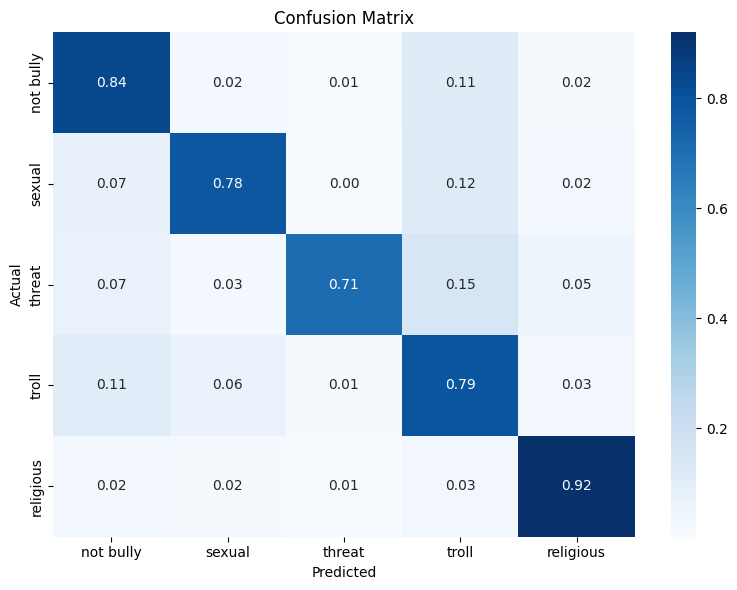

In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglishbert")
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglishbert", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Define optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop with formatted output
epochs = 5
learning_rate = 2e-5
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct, total = 0, 0, 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            "accuracy": f"{(correct / total):.4f}",
            "loss": f"{(train_loss / (total / train_dataloader.batch_size)):.4f}",
        })

    train_accuracy = correct / total
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_dataloader)

    # Fetch current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Print epoch summary
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{epochs} ━ {epoch_time:.1f}s - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f} - learning_rate: {current_lr:.6f}")

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglishbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████████████████| 959/959 [20:36<00:00,  1.29s/it, Loss=0.6014, Accuracy=0.7830]


Epoch 1 - Accuracy: 0.7830 - Loss: 0.6013


Epoch 2: 100%|██████████████████████| 959/959 [20:35<00:00,  1.29s/it, Loss=0.3178, Accuracy=0.8957]


Epoch 2 - Accuracy: 0.8957 - Loss: 0.3177


Epoch 3: 100%|██████████████████████| 959/959 [20:35<00:00,  1.29s/it, Loss=0.2141, Accuracy=0.9310]


Epoch 3 - Accuracy: 0.9310 - Loss: 0.2141


Epoch 4: 100%|██████████████████████| 959/959 [20:35<00:00,  1.29s/it, Loss=0.1465, Accuracy=0.9547]


Epoch 4 - Accuracy: 0.9547 - Loss: 0.1464


Epoch 5: 100%|██████████████████████| 959/959 [20:36<00:00,  1.29s/it, Loss=0.1014, Accuracy=0.9681]


Epoch 5 - Accuracy: 0.9681 - Loss: 0.1014

Classification Report (Test Set):

              precision    recall  f1-score   support

   not bully       0.92      0.81      0.86      1525
      sexual       0.91      0.94      0.92      1526
      threat       0.97      0.99      0.98      1512
       troll       0.83      0.90      0.86      1551
   religious       0.97      0.96      0.97      1556

    accuracy                           0.92      7670
   macro avg       0.92      0.92      0.92      7670
weighted avg       0.92      0.92      0.92      7670



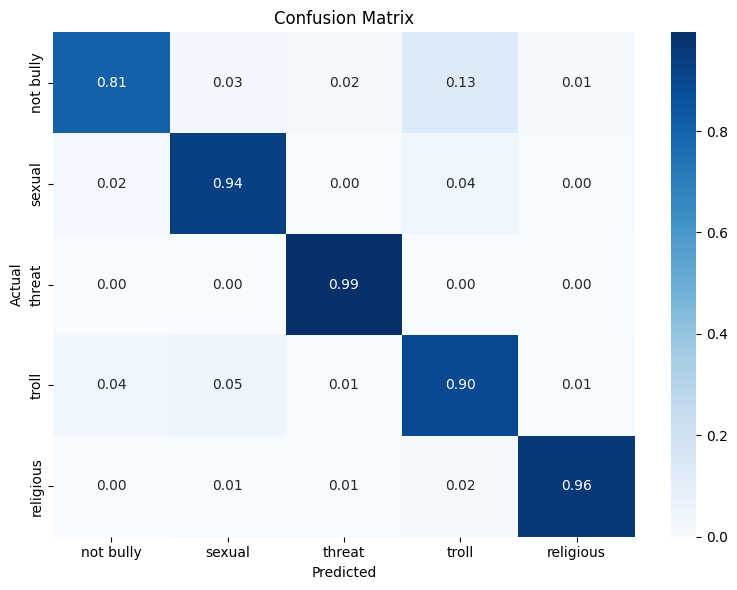

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler  # For random oversampling
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

# Load dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Random oversample using RandomOverSampler for the entire dataset
def random_oversample_data(data):
    X = data['comment'].values
    y = data['label_encoded'].values

    # Apply RandomOverSampler to oversample the dataset
    ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X.reshape(-1, 1), y)

    # Create a new DataFrame with the oversampled data
    data_resampled = pd.DataFrame({
        'comment': X_resampled.flatten(),
        'label_encoded': y_resampled
    })

    return data_resampled

# Oversample the entire dataset (train, validation, and test)
data_resampled = random_oversample_data(data)

# Split dataset into train, validation, and test (using a basic 80-10-10 split)
train_data = data_resampled.sample(frac=0.8, random_state=42)
test_val_data = data_resampled.drop(train_data.index)
val_data = test_val_data.sample(frac=0.5, random_state=42)
test_data = test_val_data.drop(val_data.index)

# Dataloaders
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglishbert")
train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Setup the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglishbert", num_labels=len(label_mapping)).to(device)

# Training settings
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # Lower learning rate for fine-tuning
criterion = torch.nn.CrossEntropyLoss()

# Train model with BERT (fine-tuning for 5 epochs)
model.train()
for epoch in range(5):  # 5 epochs
    train_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", ncols=100)

    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar with training loss and accuracy
        progress_bar.set_postfix({
            'Loss': f'{train_loss / (total / train_dataloader.batch_size):.4f}',
            'Accuracy': f'{(correct / total):.4f}'
        })

    # After each epoch, print out the final accuracy and loss
    train_accuracy = correct / total
    print(f"Epoch {epoch + 1} - Accuracy: {train_accuracy:.4f} - Loss: {train_loss / len(train_dataloader):.4f}")

# Evaluate the model on the test set
model.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

print("\nClassification Report (Test Set):\n")
print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

cm = confusion_matrix(true_labels, pred_labels, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglishbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 551/551 [13:01<00:00,  1.42s/it, Loss=0.6594, Accuracy=0.5585]


Epoch 1 - Accuracy: 0.5585 - Loss: 0.6583


Epoch 2: 100%|██████████| 551/551 [12:59<00:00,  1.42s/it, Loss=0.3107, Accuracy=0.7919]


Epoch 2 - Accuracy: 0.7919 - Loss: 0.3101


Epoch 3: 100%|██████████| 551/551 [13:01<00:00,  1.42s/it, Loss=0.2296, Accuracy=0.8416]


Epoch 3 - Accuracy: 0.8416 - Loss: 0.2292


Epoch 4: 100%|██████████| 551/551 [13:00<00:00,  1.42s/it, Loss=0.2142, Accuracy=0.8537]


Epoch 4 - Accuracy: 0.8537 - Loss: 0.2139


Epoch 5: 100%|██████████| 551/551 [13:01<00:00,  1.42s/it, Loss=0.1836, Accuracy=0.8775]


Epoch 5 - Accuracy: 0.8775 - Loss: 0.1833


Epoch 6: 100%|██████████| 551/551 [12:59<00:00,  1.41s/it, Loss=0.1775, Accuracy=0.8835]


Epoch 6 - Accuracy: 0.8835 - Loss: 0.1772


Epoch 7: 100%|██████████| 551/551 [12:59<00:00,  1.42s/it, Loss=0.1494, Accuracy=0.8991]


Epoch 7 - Accuracy: 0.8991 - Loss: 0.1491


Epoch 8: 100%|██████████| 551/551 [12:59<00:00,  1.42s/it, Loss=0.1422, Accuracy=0.9044]


Epoch 8 - Accuracy: 0.9044 - Loss: 0.1419


Epoch 9: 100%|██████████| 551/551 [12:59<00:00,  1.42s/it, Loss=0.1312, Accuracy=0.9123]


Epoch 9 - Accuracy: 0.9123 - Loss: 0.1310


Epoch 10: 100%|██████████| 551/551 [12:59<00:00,  1.41s/it, Loss=0.1175, Accuracy=0.9211]


Epoch 10 - Accuracy: 0.9211 - Loss: 0.1173

Classification Report (Test Set):

              precision    recall  f1-score   support

   not bully       0.94      0.68      0.79      1568
      sexual       0.76      0.83      0.79       870
      threat       0.68      0.84      0.75       167
       troll       0.63      0.80      0.70      1007
   religious       0.89      0.93      0.91       788

    accuracy                           0.79      4400
   macro avg       0.78      0.82      0.79      4400
weighted avg       0.81      0.79      0.79      4400



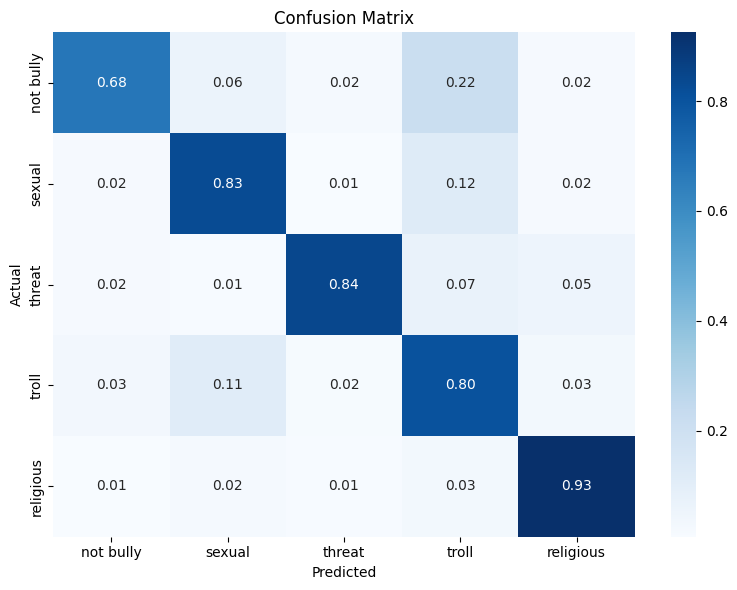

In [ ]:
import torch
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Keep only Bangla and English characters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset (80% train, 10% validation, 10% test)
train_data = data.sample(frac=0.8, random_state=42)
test_val_data = data.drop(train_data.index)
val_data = test_val_data.sample(frac=0.5, random_state=42)
test_data = test_val_data.drop(val_data.index)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Dataloaders
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglishbert")
train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

# Calculate class weights for the WeightedRandomSampler
class_counts = train_data['label_encoded'].value_counts().sort_index().tolist()
weights = [sum(class_counts) / c for c in class_counts]
sample_weights = [weights[label] for label in train_data['label_encoded']]

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader with Random Sampler
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglishbert", num_labels=len(label_mapping)).to(device)

# Define class weights for balanced training
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Train model (10 epochs with learning rate scheduling)
model.train()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

for epoch in range(10):  # Increased epochs for higher accuracy
    train_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")

    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

        progress_bar.set_postfix({'Loss': f'{train_loss / (total / train_dataloader.batch_size):.4f}',
                                  'Accuracy': f'{(correct / total):.4f}'})

    scheduler.step()

    print(f"Epoch {epoch + 1} - Accuracy: {correct / total:.4f} - Loss: {train_loss / len(train_dataloader):.4f}")

# Evaluate on test set
model.eval()
true_labels, pred_labels = [], []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

print("\nClassification Report (Test Set):\n")
print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

# Confusion matrix visualization
cm = confusion_matrix(true_labels, pred_labels, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/874 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/366k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglishbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|                                                              | 0/961 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch 1:   0%| | 3/961 [00:04<22:04,  1.38s/it, Loss=1.6192, Accuracy=0.1823, Precision=0.2001, Reca/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision a

Epoch 1 - Accuracy: 0.7813 - Loss: 0.6041


Epoch 2: 100%|█| 961/961 [22:25<00:00,  1.40s/it, Loss=0.3108, Accuracy=0.8974, Precision=0.9250, Re


Epoch 2 - Accuracy: 0.8974 - Loss: 0.3105


Epoch 3: 100%|█| 961/961 [22:25<00:00,  1.40s/it, Loss=0.2049, Accuracy=0.9360, Precision=1.0000, Re


Epoch 3 - Accuracy: 0.9360 - Loss: 0.2047


Epoch 4: 100%|█| 961/961 [22:24<00:00,  1.40s/it, Loss=0.1394, Accuracy=0.9571, Precision=1.0000, Re


Epoch 4 - Accuracy: 0.9571 - Loss: 0.1393


Epoch 5: 100%|█| 961/961 [22:25<00:00,  1.40s/it, Loss=0.1025, Accuracy=0.9684, Precision=1.0000, Re


Epoch 5 - Accuracy: 0.9684 - Loss: 0.1024


Epoch 6: 100%|█| 961/961 [22:26<00:00,  1.40s/it, Loss=0.0753, Accuracy=0.9766, Precision=1.0000, Re


Epoch 6 - Accuracy: 0.9766 - Loss: 0.0752


Epoch 7: 100%|█| 961/961 [22:26<00:00,  1.40s/it, Loss=0.0597, Accuracy=0.9816, Precision=1.0000, Re


Epoch 7 - Accuracy: 0.9816 - Loss: 0.0597


Epoch 8: 100%|█| 961/961 [22:25<00:00,  1.40s/it, Loss=0.0531, Accuracy=0.9835, Precision=1.0000, Re


Epoch 8 - Accuracy: 0.9835 - Loss: 0.0531


Epoch 9: 100%|█| 961/961 [22:25<00:00,  1.40s/it, Loss=0.0425, Accuracy=0.9868, Precision=1.0000, Re


Epoch 9 - Accuracy: 0.9868 - Loss: 0.0424


Epoch 10: 100%|█| 961/961 [22:24<00:00,  1.40s/it, Loss=0.0389, Accuracy=0.9871, Precision=1.0000, R


Epoch 10 - Accuracy: 0.9871 - Loss: 0.0389

Classification Report (Test Set):

              precision    recall  f1-score   support

   not bully       0.88      0.85      0.87      1568
      sexual       0.82      0.84      0.83       870
      threat       0.79      0.82      0.81       167
       troll       0.77      0.80      0.78      1007
   religious       0.93      0.90      0.92       788

    accuracy                           0.85      4400
   macro avg       0.84      0.84      0.84      4400
weighted avg       0.85      0.85      0.85      4400



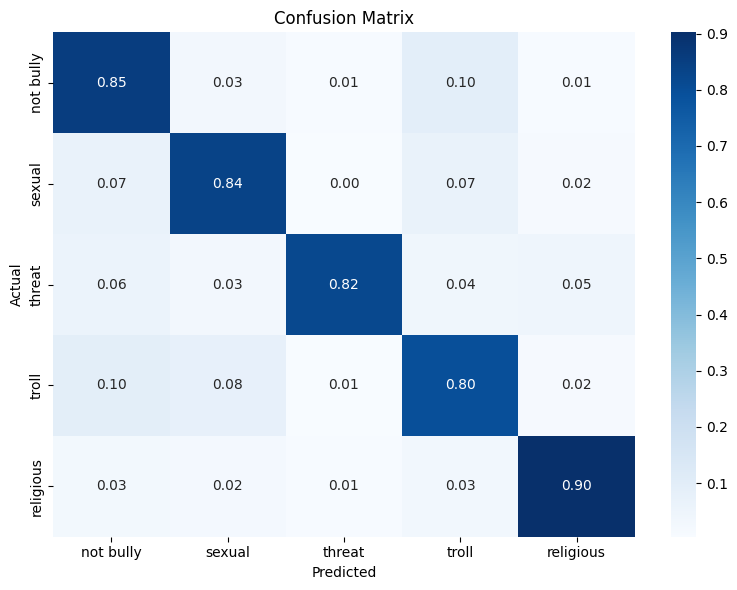

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support

# Load dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Random oversample using RandomOverSampler for the entire dataset
def random_oversample_data(data):
    X = data['comment'].values
    y = data['label_encoded'].values

    # Apply RandomOverSampler to oversample the dataset
    ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X.reshape(-1, 1), y)

    # Create a new DataFrame with the oversampled data
    data_resampled = pd.DataFrame({
        'comment': X_resampled.flatten(),
        'label_encoded': y_resampled
    })

    return data_resampled

# Apply oversampling only to the training data
train_data = data.sample(frac=0.8, random_state=42)
train_data_resampled = random_oversample_data(train_data)

# Split dataset into train, validation, and test
test_val_data = data.drop(train_data.index)
val_data = test_val_data.sample(frac=0.5, random_state=42)
test_data = test_val_data.drop(val_data.index)

# Dataloaders
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglishbert")
train_dataset = BanglaDataset(train_data_resampled, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Setup the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglishbert", num_labels=len(label_mapping)).to(device)

# Calculate class weights (for imbalanced classes)
class_weights = compute_class_weight('balanced', classes=list(label_mapping.values()), y=train_data_resampled['label_encoded'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Training settings
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # Lower learning rate for fine-tuning
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)  # Apply class weights to the loss function

# Train model with BERT (fine-tuning for 10 epochs)
model.train()
for epoch in range(10):  # Increase epochs to 10
    train_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", ncols=100)

    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar with training loss and accuracy
        precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), predicted.cpu(), average='weighted')
        progress_bar.set_postfix({
            'Loss': f'{train_loss / (total / train_dataloader.batch_size):.4f}',
            'Accuracy': f'{(correct / total):.4f}',
            'Precision': f'{precision:.4f}',
            'Recall': f'{recall:.4f}',
            'F1-score': f'{f1:.4f}'
        })

    # After each epoch, print out the final accuracy and loss
    train_accuracy = correct / total
    print(f"Epoch {epoch + 1} - Accuracy: {train_accuracy:.4f} - Loss: {train_loss / len(train_dataloader):.4f}")

# Evaluate the model on the test set
model.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

print("\nClassification Report (Test Set):\n")
print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_cosine_schedule_with_warmup
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
import numpy as np
import random

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Enhanced data cleaning with Banglish handling
def clean_text(text):
    # Remove unwanted characters (URLs, special symbols, etc.)
    text = re.sub(r'https?://\S+|www\.\S+|[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Remove URLs & symbols
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    # Tokenization and Banglish handling
    # Ideally, you would want a Banglish detector here, this is a placeholder for demonstration
    text = ' '.join([word if word.isalpha() else '' for word in text.split()])  # Remove numeric tokens

    # Apply more specific cleaning and lemmatization (assuming lemmatizer is available, like spaCy for Bangla)
    # Here we can apply basic stemming or lemmatization as needed

    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=seed)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=seed)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglishbert")
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglishbert", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Apply SMOTE to balance the dataset
X_train = [item['comment'] for item in train_dataset]
y_train = [item['labels'] for item in train_dataset]

# Convert text to numerical format (e.g., TF-IDF Vectorization)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE(random_state=seed)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# Recreate the DataLoader for the oversampled data
train_dataset_resampled = BanglaDataset(data=pd.DataFrame({"comment": X_train_res, "label_encoded": y_train_res}), tokenizer=tokenizer, max_length=128)
train_dataloader_resampled = DataLoader(train_dataset_resampled, batch_size=32, shuffle=True)

# Define optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Learning rate scheduler with warm-up and cosine annealing
total_steps = len(train_dataloader_resampled) * 5  # Total number of training steps
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop with gradient clipping and early stopping
epochs = 8
best_val_accuracy = 0
patience = 2  # Number of epochs with no improvement before stopping
early_stopping_counter = 0

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct, total = 0, 0, 0

    progress_bar = tqdm(train_dataloader_resampled, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()

        # Gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            "accuracy": f"{(correct / total):.4f}",
            "loss": f"{(train_loss / (total / train_dataloader_resampled.batch_size)):.4f}",
        })

    train_accuracy = correct / total
    train_loss /= len(train_dataloader_resampled)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_dataloader)

    # Print epoch summary
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{epochs} ━ {epoch_time:.1f}s - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")



# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/874 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/366k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglishbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyError: 'comment'

In [ ]:

!pip install git+https://github.com/csebuetnlp/normalizer
!pip install transformers




import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Oversample minority classes using SMOTE (on TF-IDF vectors)
X_train, y_train = train_data['comment'], train_data['label_encoded']

# Convert text to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Apply SMOTE to oversample
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_train_tfidf, y_train)

# Shuffle the resampled dataset
X_res, y_res = shuffle(X_res, y_res, random_state=42)

# Convert oversampled data back to a DataFrame for further processing
train_data_resampled = pd.DataFrame(X_res.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
train_data_resampled['label_encoded'] = y_res

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]

        # Ensure that the text is a valid string
        if not isinstance(text, str):
            text = str(text)  # Convert to string if it's not

        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }


# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglishbert")
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglishbert", num_labels=len(label_mapping)).to(device)

# Use oversampled data for training
train_dataset = BanglaDataset(train_data_resampled, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Define optimizer, loss function with class weights, and learning rate scheduler
class_weights = torch.tensor([1.0, 2.0, 3.0, 1.5, 2.5]).to(device)  # Example class weights; adjust based on your data
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 5

# Training loop with formatted output
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct, total = 0, 0, 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            "accuracy": f"{(correct / total):.4f}",
            "loss": f"{(train_loss / (total / train_dataloader.batch_size)):.4f}",
        })

    train_accuracy = correct / total
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_dataloader)

    # Fetch current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Print epoch summary
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{epochs} ━ {epoch_time:.1f}s - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f} - learning_rate: {current_lr:.6f}")

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-_k6a8yjm
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-_k6a8yjm
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done


`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglishbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5:  10%|█         | 161/1535 [01:53<16:06,  1.42it/s, accuracy=0.1908, loss=1.5592]


KeyboardInterrupt: 

# Explainable AI

In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import shap
from lime.lime_text import LimeTextExplainer

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^ঀ-৿a-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Define optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop with formatted output
epochs = 5
learning_rate = 2e-5
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct, total = 0, 0, 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            "accuracy": f"{(correct / total):.4f}",
            "loss": f"{(train_loss / (total / train_dataloader.batch_size)):.4f}",
        })

    train_accuracy = correct / total
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_dataloader)

    # Fetch current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Print epoch summary
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{epochs} ━ {epoch_time:.1f}s - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f} - learning_rate: {current_lr:.6f}")

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)

# Explainability using SHAP
def explain_with_shap(model, tokenizer, texts, max_length):
    explainer = shap.Explainer(lambda x: model(
        tokenizer(x, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device))
        .logits.detach().cpu().numpy(),
        texts
    )
    shap_values = explainer(texts)
    shap.summary_plot(shap_values, texts)

# Example usage of SHAP
sample_texts = ["আপনার ধর্ম নিয়ে আপত্তিকর মন্তব্য করা ঠিক নয়।", "তোমাকে জুতা পেটা করা উচিত।"]
explain_with_shap(model, tokenizer, sample_texts, max_length=128)

# Explainability using LIME
lime_explainer = LimeTextExplainer(class_names=list(label_mapping.keys()))
def explain_with_lime(text, model, tokenizer, max_length):
    def predict_proba(texts):
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
        outputs = model(**inputs).logits.detach().cpu().numpy()
        return outputs

    explanation = lime_explainer.explain_instance(text, predict_proba, num_features=10)
    explanation.show_in_notebook()

# Example usage of LIME
example_text = "তোমাকে জুতা পেটা করা উচিত।"
explain_with_lime(example_text, model, tokenizer, max_length=128)

In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import shap
from lime.lime_text import LimeTextExplainer

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }


# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-large", num_labels=len(label_mapping)
).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Define optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 1
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct, total = 0, 0, 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            "accuracy": f"{(correct / total):.4f}",
            "loss": f"{(train_loss / (total / train_dataloader.batch_size)):.4f}",
        })

    train_accuracy = correct / total
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_dataloader)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{epochs} ━ {epoch_time:.1f}s - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")

# Evaluate and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)



In [ ]:
import shap
import numpy as np  # Import numpy for handling arrays

def explain_with_shap_bar_plot(model, tokenizer, texts, max_length):
    # Define a model wrapper for SHAP
    def model_wrapper(input_texts):
        if isinstance(input_texts, np.ndarray):  # Convert SHAP's masked inputs back to text
            input_texts = ["".join([t for t in text if t != "[MASK]"]) for text in input_texts]

        encoding = tokenizer(
            input_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask).logits
        return outputs.cpu().detach().numpy()

    # Initialize SHAP Explainer
    masker = shap.maskers.Text(tokenizer)  # Create a text masker
    explainer = shap.Explainer(model_wrapper, masker)

    # Explain the provided texts
    shap_values = explainer(texts, max_evals=500, batch_size=16)

    # Generate a SHAP bar plot
    shap.summary_plot(shap_values.values, shap_values.feature_names, plot_type="bar")

# Example usage of the corrected function
sample_texts = ["তোমাকে জুতা পেটা করা উচিত।"]
explain_with_shap_bar_plot(model, tokenizer, sample_texts, max_length=128)


NameError: name 'model' is not defined

In [ ]:
import shap
import numpy as np  # Import numpy for handling arrays

def explain_with_shap(model, tokenizer, texts, max_length):
    # Define a model wrapper for SHAP
    def model_wrapper(input_texts):
        if isinstance(input_texts, np.ndarray):  # Convert SHAP's masked inputs back to text
            input_texts = ["".join([t for t in text if t != "[MASK]"]) for text in input_texts]

        encoding = tokenizer(
            input_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask).logits
        return outputs.cpu().detach().numpy()

    # Initialize SHAP Explainer
    masker = shap.maskers.Text(tokenizer)  # Create a text masker
    explainer = shap.Explainer(model_wrapper, masker)

    # Explain the provided texts
    shap_values = explainer(texts, max_evals=500, batch_size=16)

    # Visualize the results
    shap.text_plot(shap_values)

# Example usage of the corrected function
sample_texts ="তোমাকে জুতা পেটা করা উচিত।"
explain_with_shap(model, tokenizer, sample_texts, max_length=128)


NameError: name 'model' is not defined

In [ ]:
!pip install lime

from lime.lime_text import LimeTextExplainer

# Define a predict function for LIME
def lime_predict(texts):
    encoding = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get model predictions
    outputs = model(input_ids, attention_mask=attention_mask).logits
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.detach().cpu().numpy()

# Initialize LIME Explainer
explainer = LimeTextExplainer(class_names=list(label_mapping.keys()))

# Example text to explain
example_text = "তোমাকে জুতা পেটা করা উচিত"

# Generate LIME explanation
exp = explainer.explain_instance(
    example_text,
    lime_predict,  # Pass the prediction function
    num_features=10,  # Number of words to explain in the visualization
    labels=[0, 1, 2, 3, 4]  # The labels (classes) you want explanations for
)

# Visualize the explanation for a specific class (e.g., class 2)
exp.show_in_notebook(text=True)

# Save the explanation as an HTML file (optional)
exp.save_to_file('lime_explanation.html')


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 78.12 MiB is free. Process 36608 has 14.66 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 300.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification, GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# GAN-based Synthetic Data Generation
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")
model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")

# Set pad_token_id explicitly for GPT-2
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token  # Set pad_token to eos_token to prevent warnings

def generate_synthetic_text(prompt, max_length=50):
    input_ids = tokenizer_gpt2.encode(prompt, return_tensors="pt")
    attention_mask = input_ids != tokenizer_gpt2.pad_token_id  # Generate attention mask
    outputs = model_gpt2.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        num_return_sequences=1,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer_gpt2.pad_token_id,
    )
    return tokenizer_gpt2.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

# Generate synthetic comments
synthetic_data = []
for label, count in label_mapping.items():
    for _ in range(100):  # Adjust the number of synthetic samples as needed
        prompt = f"Generate a {label} comment: "
        comment = generate_synthetic_text(prompt)
        synthetic_data.append({"comment": comment, "label": label})

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)
synthetic_df['label_encoded'] = synthetic_df['label'].map(label_mapping)
synthetic_df['comment'] = synthetic_df['comment'].apply(clean_text)

# Combine synthetic data with train_data
augmented_train_data = pd.concat([train_data, synthetic_df], ignore_index=True)

# Prepare datasets and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(augmented_train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Define optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 10
learning_rate = 2e-5

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct, total = 0, 0, 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({"accuracy": f"{(correct / total):.4f}"})

    train_accuracy = correct / total
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_dataloader)

    # Print epoch summary
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{epochs} ━ {epoch_time:.1f}s - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f} - learning_rate: {learning_rate:.4f}")

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification, GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split




# Check if GPU is available
import torch
if torch.cuda.is_available():
    print("GPU is available and being used.")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available. Using CPU instead.")

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^ঀ-৿a-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# GAN-based Synthetic Data Generation
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")
model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")

# Set pad_token_id explicitly for GPT-2
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token  # Set pad_token to eos_token to prevent warnings

def generate_synthetic_text(prompt, max_length=50):
    input_ids = tokenizer_gpt2.encode(prompt, return_tensors="pt")
    attention_mask = input_ids != tokenizer_gpt2.pad_token_id  # Generate attention mask
    outputs = model_gpt2.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        num_return_sequences=1,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer_gpt2.pad_token_id,
    )
    return tokenizer_gpt2.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

# Generate synthetic comments
synthetic_data = []
for label, count in label_mapping.items():
    for _ in range(100):  # Adjust the number of synthetic samples as needed
        prompt = f"Generate a {label} comment: "
        comment = generate_synthetic_text(prompt)
        synthetic_data.append({"comment": comment, "label": label})

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)
synthetic_df['label_encoded'] = synthetic_df['label'].map(label_mapping)
synthetic_df['comment'] = synthetic_df['comment'].apply(clean_text)

# Combine synthetic data with train_data
augmented_train_data = pd.concat([train_data, synthetic_df], ignore_index=True)

# Prepare datasets and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=len(label_mapping)).to(device)






train_dataset = BanglaDataset(augmented_train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Define optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 5
learning_rate = 2e-5

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct, total = 0, 0, 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({"accuracy": f"{(correct / total):.4f}"})

    train_accuracy = correct / total
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_dataloader)

    # Print epoch summary
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{epochs} ━ {epoch_time:.1f}s - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f} - learning_rate: {learning_rate:.4f}")

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from torch import nn, optim

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# GAN for Synthetic Data Generation
class Generator(nn.Module):
    def __init__(self, z_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# GAN setup
z_dim = 100
output_dim = 300  # Approximate length of a synthetic comment
generator = Generator(z_dim, output_dim).to(device)
discriminator = Discriminator(output_dim).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
criterion = nn.BCELoss()

import numpy as np

# Generate synthetic data with GAN
synthetic_data = []
generator.eval()
for _ in range(500):  # Generate 500 synthetic comments
    z = torch.randn(1, z_dim).to(device)  # Random noise for GAN input
    with torch.no_grad():
        generated_comment = generator(z).cpu().numpy().flatten()
        # Convert the GAN output to a string (interpret as characters)
        synthetic_comment = ''.join([chr(int(abs(i) % 1114111)) for i in generated_comment])  # Handle valid Unicode range
        synthetic_data.append({"comment": synthetic_comment, "label_encoded": 0})  # Assuming "not bully"

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Combine synthetic data with the training data
train_data = pd.concat([train_data, synthetic_df], ignore_index=True)

# Redefine training dataset and dataloader
train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop with formatted output
epochs = 5
learning_rate = 2e-5

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct, total = 0, 0, 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            "accuracy": f"{(correct / total):.4f}",
            "loss": f"{(train_loss / (total / train_dataloader.batch_size)):.4f}",
        })

    train_accuracy = correct / total
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_dataloader)

    # Print epoch summary
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{epochs} ━ {epoch_time:.1f}s - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f} - learning_rate: {learning_rate:.4f}")

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


In [ ]:

!pip install git+https://github.com/csebuetnlp/normalizer
!pip install transformers




import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import shap
from lime.lime_text import LimeTextExplainer

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Data cleaning
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }


# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-large", num_labels=len(label_mapping)
).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Define optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 1
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss, correct, total = 0, 0, 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            "accuracy": f"{(correct / total):.4f}",
            "loss": f"{(train_loss / (total / train_dataloader.batch_size)):.4f}",
        })

    train_accuracy = correct / total
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_dataloader)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{epochs} ━ {epoch_time:.1f}s - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")

# Evaluate and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-48_15ju5
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-48_15ju5
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/1:   1%|          | 25/3520 [00:20<47:59,  1.21it/s, accuracy=0.3250, loss=1.5030]


KeyboardInterrupt: 

# GAN+XLM_ROBERTa base

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install transformers
!pip install imbalanced-learn

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Advanced Data Cleaning
def clean_text(text):
    text = re.sub(r'[^ঀ-৿a-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define GAN-based synthetic data generation
class GANGenerator(torch.nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(GANGenerator, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(noise_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, output_dim),
            torch.nn.Tanh()
        )

    def forward(self, noise):
        return self.fc(noise)

def generate_synthetic_data(train_data, label_mapping, num_samples=500):
    noise_dim = 100
    text_length = 50
    generator = GANGenerator(noise_dim, text_length).train()

    synthetic_data = []
    for label, encoded_label in label_mapping.items():
        for _ in range(num_samples):
            noise = torch.randn(1, noise_dim)
            fake_text = generator(noise).detach().numpy()
            text = ''.join([chr(int(abs(char)) % 1114111) for char in fake_text[0]])
            text = ''.join([char if char.isprintable() else ' ' for char in text])  # Clean non-printable chars
            synthetic_data.append({'comment': text, 'label': label, 'label_encoded': encoded_label})
    return pd.DataFrame(synthetic_data)

synthetic_data = generate_synthetic_data(train_data, label_mapping)
train_data = pd.concat([train_data, synthetic_data], ignore_index=True)

# Oversampling function using SMOTE for text data
def oversample_data(data, label_mapping):
    max_count = data['label_encoded'].value_counts().max()
    oversampled_data = []

    for label, encoded_label in label_mapping.items():
        class_data = data[data['label_encoded'] == encoded_label]
        while len(class_data) < max_count:
            class_data = pd.concat([class_data, class_data], ignore_index=True)  # Oversampling by duplication
        oversampled_data.append(class_data)

    return pd.concat(oversampled_data, ignore_index=True)

# Oversample training data
train_data_oversampled = oversample_data(train_data, label_mapping)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Logging function for loss and accuracy
def log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc):
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}\n")

# Training function with progress bar that shows loss and accuracy
# Training function with progress bar that shows loss and accuracy
def train(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    train_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(dataloader, desc="Training", ncols=100)  # Create progress bar instance
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar with loss and accuracy
        avg_loss = train_loss / (len(dataloader) + 1e-5)
        avg_acc = correct / (total + 1e-5)
        progress_bar.set_postfix({"Loss": avg_loss, "Accuracy": avg_acc})  # Update progress bar

    return train_loss / len(dataloader), correct / total


# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    valid_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation", ncols=100):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return valid_loss / len(dataloader), correct / total

# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglishbert")
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglishbert", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(train_data_oversampled, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Define optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_dataloader, optimizer, scheduler, criterion)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)
    log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc)

# Evaluate the model with confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-f70a_ig1
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-f70a_ig1
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done


`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglishbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Training:   4%|▉                     | 79/1891 [00:57<22:00,  1.37it/s, Loss=0.0668, Accuracy=0.255]


KeyboardInterrupt: 

# GAN+BanglihBERT

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install transformers







import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# Load and preprocess dataset
file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'  # Replace with actual dataset path
data = pd.read_excel(file_path)
data = data.dropna(subset=['comment', 'label'])

# Encode labels
label_mapping = {"not bully": 0, "sexual": 1, "threat": 2, "troll": 3, "religious": 4}
data['label'] = data['label'].str.lower().str.strip()
data['label_encoded'] = data['label'].map(label_mapping)

# Advanced Data Cleaning
def clean_text(text):
    text = re.sub(r'[^ঀ-৿a-zA-Z0-9\s]', '', text)  # Remove non-Bangla/non-English characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['comment'] = data['comment'].apply(clean_text)

# Split dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label_encoded'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label_encoded'], random_state=42)

# Define GAN-based synthetic data generation
class GANGenerator(torch.nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(GANGenerator, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(noise_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, output_dim),
            torch.nn.Tanh()
        )

    def forward(self, noise):
        return self.fc(noise)

def generate_synthetic_data(train_data, label_mapping, num_samples=500):
    noise_dim = 100
    text_length = 50
    generator = GANGenerator(noise_dim, text_length).train()

    synthetic_data = []
    for label, encoded_label in label_mapping.items():
        for _ in range(num_samples):
            noise = torch.randn(1, noise_dim)
            fake_text = generator(noise).detach().numpy()
            text = ''.join([chr(int(abs(char)) % 1114111) for char in fake_text[0]])
            text = ''.join([char if char.isprintable() else ' ' for char in text])  # Clean non-printable chars
            synthetic_data.append({'comment': text, 'label': label, 'label_encoded': encoded_label})
    return pd.DataFrame(synthetic_data)

synthetic_data = generate_synthetic_data(train_data, label_mapping)
train_data = pd.concat([train_data, synthetic_data], ignore_index=True)

# Define custom dataset class
class BanglaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.comments = data['comment'].tolist()
        self.labels = data['label_encoded'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Logging function for loss and accuracy
def log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc):
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}\n")

# Training function
def train(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return train_loss / len(dataloader), correct / total

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    valid_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return valid_loss / len(dataloader), correct / total

# Setup model, tokenizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglishbert")
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglishbert", num_labels=len(label_mapping)).to(device)

train_dataset = BanglaDataset(train_data, tokenizer, max_length=128)
val_dataset = BanglaDataset(val_data, tokenizer, max_length=128)
test_dataset = BanglaDataset(test_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Define optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_dataloader, optimizer, scheduler, criterion)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)
    log_epoch_performance(epoch, train_loss, train_acc, valid_loss, valid_acc)

# Evaluate the model and plot confusion matrix
def evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# Evaluate and plot confusion matrix
evaluate_model_with_confusion_matrix(model, test_dataloader, label_mapping)


  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-oodgf0tv
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-oodgf0tv
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=1effe11098b1e59d43bc7e19e167c7ac5a0de855bd52d1c72ae75a5071f39729
  Stored in directory: /tmp/pip-ephem-wheel-cache-rzy27jfz/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=0c69e0fa23802ad8a8c434e897338b4023a2a82

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/874 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/366k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglishbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Training:   0%|          | 0/480 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 16.12 MiB is free. Process 3826 has 14.72 GiB memory in use. Of the allocated memory 14.48 GiB is allocated by PyTorch, and 117.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx


--2025-02-08 07:10:13--  https://github.com/google/fonts/raw/main/ofl/notosansbengali/NotoSansBengali%5Bwdth%2Cwght%5D.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/notosansbengali/NotoSansBengali%5Bwdth%2Cwght%5D.ttf [following]
--2025-02-08 07:10:14--  https://raw.githubusercontent.com/google/fonts/main/ofl/notosansbengali/NotoSansBengali%5Bwdth%2Cwght%5D.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 624604 (610K) [application/octet-stream]
Saving to: ‘NotoSansBengali[wdth,wght].ttf’

NotoSansBengali[wdt 100%[===================>] 609.96K  --.-KB/s    in 0.05s

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training...

Epoch 1/1


Evaluating: 100%|██████████| 551/551 [04:07<00:00,  2.22it/s]


Train Loss: 1.3087 | Train Acc: 42.49%
Val Loss: 1.5204 | Val Acc: 34.86%

Plotting training history...


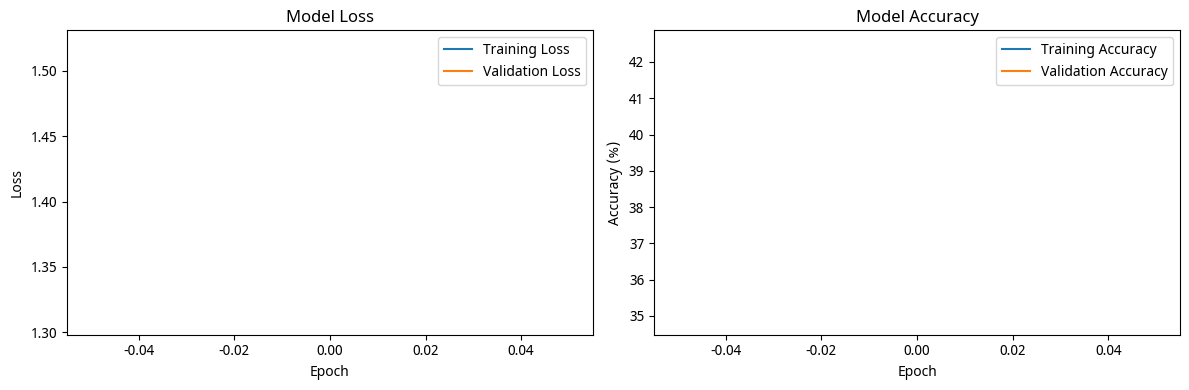


Generating confusion matrix...


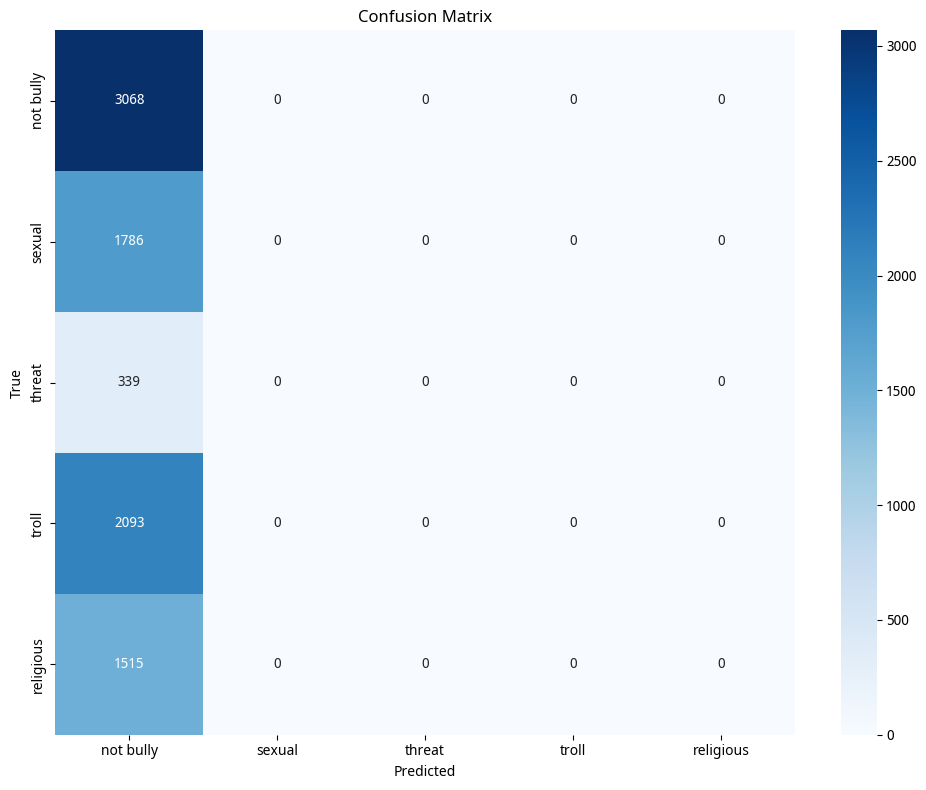


Classification Report:
              precision    recall  f1-score   support

   not bully       0.35      1.00      0.52      3068
      sexual       0.00      0.00      0.00      1786
      threat       0.00      0.00      0.00       339
       troll       0.00      0.00      0.00      2093
   religious       0.00      0.00      0.00      1515

    accuracy                           0.35      8801
   macro avg       0.07      0.20      0.10      8801
weighted avg       0.12      0.35      0.18      8801

চোরের মার বড় গলা


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

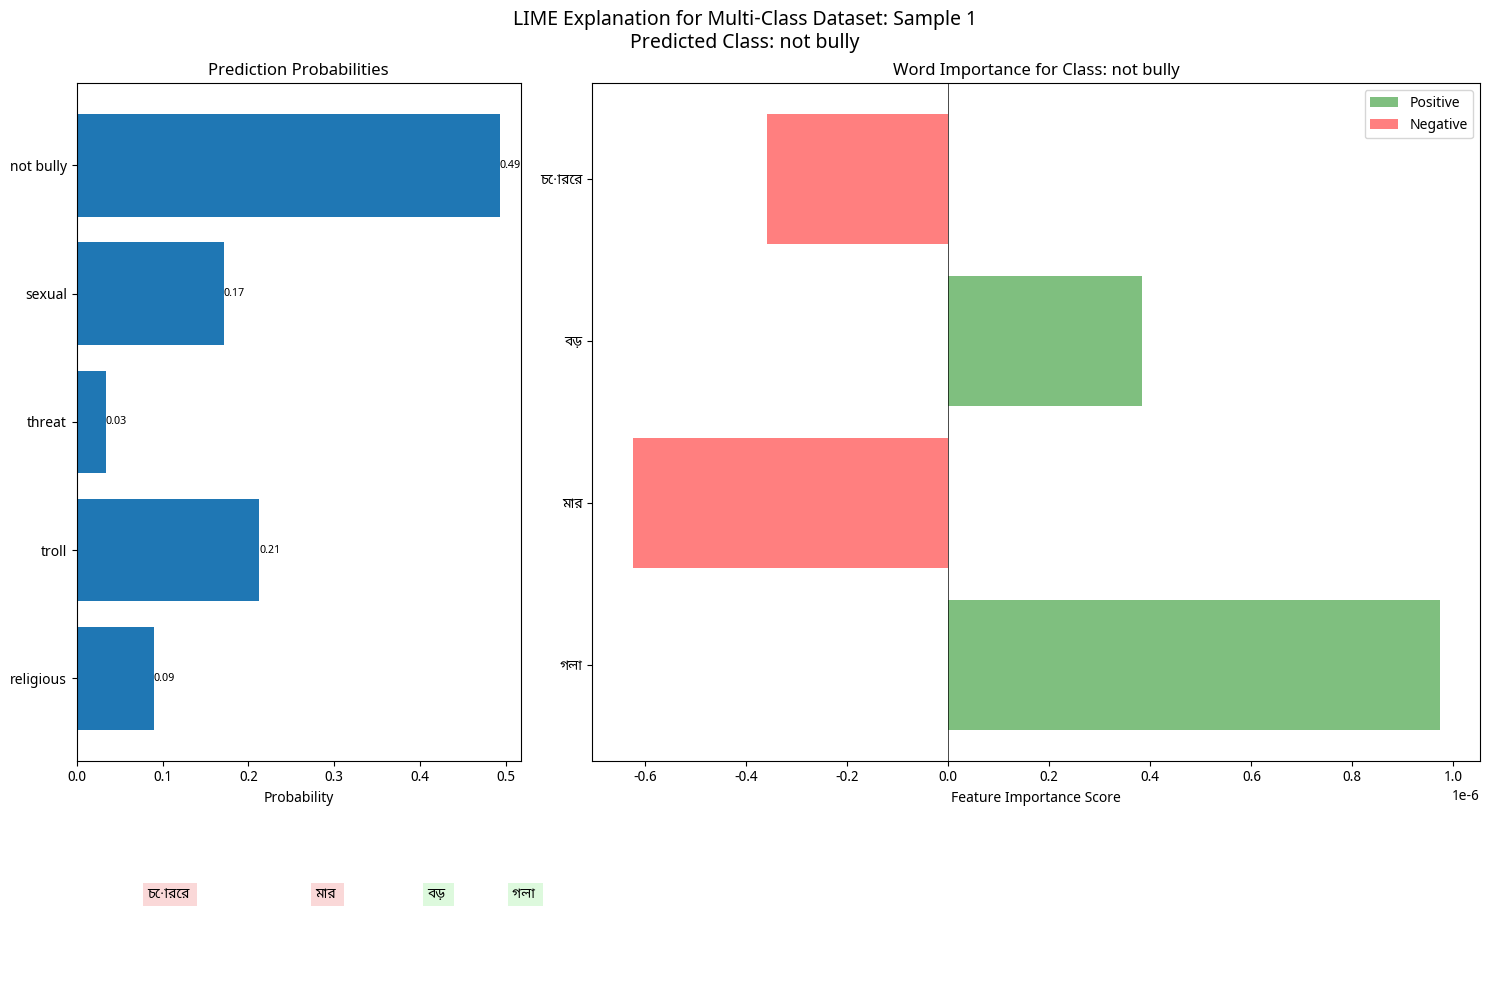

In [ ]:
# First, add these cells at the beginning of your notebook to install Bengali fonts
!wget https://github.com/google/fonts/raw/main/ofl/notosansbengali/NotoSansBengali%5Bwdth%2Cwght%5D.ttf
!mkdir -p ~/.fonts
!mv "NotoSansBengali[wdth,wght].ttf" ~/.fonts/
!fc-cache -f -v

# Rest of the imports
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from lime.lime_text import LimeTextExplainer
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
from matplotlib.gridspec import GridSpec
from collections import defaultdict

# Add the font to matplotlib
font_manager.fontManager.addfont(f"{os.path.expanduser('~')}/.fonts/NotoSansBengali[wdth,wght].ttf")

# Configure matplotlib to use Bengali font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Noto Sans Bengali']
plt.rcParams['axes.unicode_minus'] = False

# Rest of the code remains the same
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 1
LEARNING_RATE = 2e-5

label_mapping = {
    "not bully": 0,
    "sexual": 1,
    "threat": 2,
    "troll": 3,
    "religious": 4
}

def clean_text(text):
    # Preserve Bengali characters while cleaning
    text = re.sub(r'[^\u0980-\u09FF\s]', '', str(text))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def split_bengali_text(text):
    # Split Bengali text into words while preserving complete words
    words = text.split()
    return words

class ModelTrainer:
    def __init__(self, model, tokenizer, device, label_mapping):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.label_mapping = label_mapping
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }

    def create_dataloader(self, texts, labels, batch_size):
        # Convert numpy arrays to lists for the tokenizer
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()

        encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH,
            return_tensors='pt'
        )

        dataset = TensorDataset(
            encodings['input_ids'],
            encodings['attention_mask'],
            torch.tensor(labels)
        )
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    def train_epoch(self, train_dataloader, optimizer, criterion):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(train_dataloader, desc="Training"):
            input_ids, attention_mask, labels = [b.to(self.device) for b in batch]

            optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_dataloader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy

    def evaluate(self, val_dataloader, criterion):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Evaluating"):
                input_ids, attention_mask, labels = [b.to(self.device) for b in batch]

                outputs = self.model(input_ids, attention_mask=attention_mask).logits
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(val_dataloader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy, all_preds, all_labels

    def plot_training_history(self):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Training Accuracy')
        plt.plot(self.history['val_acc'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_mapping.keys(),
                   yticklabels=self.label_mapping.keys())
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

"""class EnhancedTextExplainer:
    def __init__(self, model, tokenizer, label_mapping):
        self.model = model
        self.tokenizer = tokenizer
        self.label_mapping = label_mapping
        self.reverse_label_mapping = {v: k for k, v in label_mapping.items()}
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def predict_proba(self, texts):
        self.model.eval()
        with torch.no_grad():
            inputs = self.tokenizer(
                texts,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            ).to(self.device)

            outputs = self.model(**inputs)
            probas = torch.softmax(outputs.logits, dim=-1)
            return probas.cpu().numpy()

    def create_prediction_probability_plot(self, probas, ax):
        classes = list(self.label_mapping.keys())
        y_pos = np.arange(len(classes))

        # Create horizontal bar chart for probabilities
        bars = ax.barh(y_pos, probas, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(classes)
        ax.invert_yaxis()
        ax.set_xlabel('Probability')
        ax.set_title('Prediction probabilities')

        # Add probability values at the end of each bar
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f'{probas[i]:.2f}',
                   ha='left', va='center', fontsize=8)

    def create_word_importance_plot(self, exp_list, ax, is_religious=False):
        words = [x[0] for x in exp_list]
        scores = [x[1] for x in exp_list]

        # Create positive and negative score lists for separate visualization
        pos_scores = [max(0, score) for score in scores]
        neg_scores = [min(0, score) for score in scores]

        # Set up the plot
        y_pos = np.arange(len(words))
        ax.set_title('NOT Religious' if not is_religious else 'Religious',
                    color='blue' if not is_religious else 'red')

        # Plot positive and negative bars separately
        ax.barh(y_pos, pos_scores, align='center', color='blue', alpha=0.5)
        ax.barh(y_pos, neg_scores, align='center', color='red', alpha=0.5)

        # Customize appearance
        ax.set_yticks(y_pos)
        ax.set_yticklabels(words)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    def explain_with_lime(self, text, num_features=10, title="LIME Explanation for Multi-Class Dataset"):
        # Create explainer
        explainer = LimeTextExplainer(
            class_names=list(self.label_mapping.keys()),
            split_expression=split_bengali_text
        )

        # Generate explanation
        exp = explainer.explain_instance(
            text,
            self.predict_proba,
            num_features=num_features,
            num_samples=100
        )

        # Get prediction probabilities
        pred_probs = self.predict_proba([text])[0]

        # Create figure with subplots
        fig = plt.figure(figsize=(15, 8))
        gs = GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1])

        # Prediction probabilities plot
        ax_prob = fig.add_subplot(gs[:, 0])
        self.create_prediction_probability_plot(pred_probs, ax_prob)

        # Word importance plots
        ax_imp1 = fig.add_subplot(gs[0, 1])
        ax_imp2 = fig.add_subplot(gs[1, 1])

        # Get explanation data and create both visualizations
        exp_list = exp.as_list()
        self.create_word_importance_plot(exp_list, ax_imp1, is_religious=False)
        self.create_word_importance_plot(exp_list, ax_imp2, is_religious=True)

        # Add the original text at the bottom
        plt.figtext(0.5, 0.02, f'Text with highlighted words: {text}',
                   ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

        # Add title
        plt.suptitle(title, fontsize=14)

        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.9, bottom=0.1)
        plt.show()"""

class EnhancedTextExplainer:
    def __init__(self, model, tokenizer, label_mapping):
        self.model = model
        self.tokenizer = tokenizer
        self.label_mapping = label_mapping
        self.reverse_label_mapping = {v: k for k, v in label_mapping.items()}
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def predict_proba(self, texts):
        self.model.eval()
        with torch.no_grad():
            inputs = self.tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(self.device)
            outputs = self.model(**inputs)
            probas = torch.softmax(outputs.logits, dim=-1)
            return probas.cpu().numpy()

    def create_prediction_probability_plot(self, probas, ax):
        classes = list(self.label_mapping.keys())
        y_pos = np.arange(len(classes))
        bars = ax.barh(y_pos, probas, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(classes)
        ax.invert_yaxis()
        ax.set_xlabel('Probability')
        ax.set_title('Prediction Probabilities')

        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, f'{probas[i]:.2f}',
                   ha='left', va='center', fontsize=8)

    def create_word_importance_plot(self, exp_list, predicted_class, ax):
        words = [x[0] for x in exp_list]
        scores = [x[1] for x in exp_list]

        y_pos = np.arange(len(words))
        ax.set_title(f'Word Importance for Class: {predicted_class}')

        # Create positive and negative contribution bars
        pos_scores = [max(0, score) for score in scores]
        neg_scores = [min(0, score) for score in scores]

        # Plot positive contributions in green and negative in red
        ax.barh(y_pos, pos_scores, align='center', color='green', alpha=0.5, label='Positive')
        ax.barh(y_pos, neg_scores, align='center', color='red', alpha=0.5, label='Negative')

        ax.set_yticks(y_pos)
        ax.set_yticklabels(words)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax.set_xlabel('Feature Importance Score')
        ax.legend()

    def explain_with_lime(self, text, num_features=10, title="LIME Explanation"):
        explainer = LimeTextExplainer(
            class_names=list(self.label_mapping.keys()),
            split_expression=split_bengali_text
        )

        # Get prediction probabilities and predicted class
        pred_probs = self.predict_proba([text])[0]
        predicted_class_idx = np.argmax(pred_probs)
        predicted_class = list(self.label_mapping.keys())[predicted_class_idx]

        # Generate explanation
        exp = explainer.explain_instance(
            text,
            self.predict_proba,
            num_features=num_features,
            num_samples=100
        )

        plt.clf()
        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(3, 2, figure=fig, width_ratios=[1, 2], height_ratios=[2, 2, 1])

        # Prediction probabilities plot
        ax_prob = fig.add_subplot(gs[:2, 0])
        self.create_prediction_probability_plot(pred_probs, ax_prob)

        # Word importance plot for predicted class
        ax_imp = fig.add_subplot(gs[0:2, 1])
        exp_list = exp.as_list()
        self.create_word_importance_plot(exp_list, predicted_class, ax_imp)

        # Text with highlighting
        ax_text = fig.add_subplot(gs[2, :])
        ax_text.set_axis_off()

        # Create text with highlighted words
        words = text.split()
        x_pos = 0.05
        y_pos = 0.5

        for word in words:
            color = None
            for exp_word, score in exp_list:
                if exp_word in word:
                    color = 'lightgreen' if score > 0 else 'lightcoral'
                    break

            if color:
                bbox = dict(facecolor=color, alpha=0.3, edgecolor='none', pad=3)
            else:
                bbox = None

            ax_text.text(x_pos, y_pos, word + ' ', fontsize=10, bbox=bbox, transform=ax_text.transAxes)
            x_pos += len(word) * 0.02 + 0.02

        plt.suptitle(f"{title}\nPredicted Class: {predicted_class}", fontsize=14)
        plt.tight_layout()

        return fig

def classification_report_with_zero_division(y_true, y_pred, target_names):
    return classification_report(y_true, y_pred, target_names=target_names, zero_division=1)

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    print("Loading data...")
    file_path = '/kaggle/input/cyberbullying/bangla_online_comments_dataset.xlsx'
    data = pd.read_excel(file_path)
    data = data.dropna(subset=['comment', 'label'])

    data['comment'] = data['comment'].apply(clean_text)
    data['label'] = data['label'].str.lower().str.strip()
    data['label_encoded'] = data['label'].map(label_mapping)
    X_train, X_test, y_train, y_test = train_test_split(
        data['comment'].values,
        data['label_encoded'].values,
        test_size=0.2,
        random_state=42,
        stratify=data['label_encoded'].values
    )

    print("Loading XLM-RoBERTa-large model...")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained(
        "xlm-roberta-large",
        num_labels=len(label_mapping)
    ).to(device)

    trainer = ModelTrainer(model, tokenizer, device, label_mapping)

    # Create dataloaders
    train_dataloader = trainer.create_dataloader(X_train, y_train, BATCH_SIZE)
    val_dataloader = trainer.create_dataloader(X_test, y_test, BATCH_SIZE)

    # Training setup
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    print("\nStarting training...")
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")

        # Train
        train_loss, train_acc = trainer.train_epoch(train_dataloader, optimizer, criterion)

        # Evaluate
        val_loss, val_acc, val_preds, val_labels = trainer.evaluate(val_dataloader, criterion)

        # Store metrics
        trainer.history['train_loss'].append(train_loss)
        trainer.history['train_acc'].append(train_acc)
        trainer.history['val_loss'].append(val_loss)
        trainer.history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Plot training history
    print("\nPlotting training history...")
    trainer.plot_training_history()

    # Plot confusion matrix
    print("\nGenerating confusion matrix...")
    trainer.plot_confusion_matrix(val_labels, val_preds)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        val_labels,
        val_preds,
        target_names=label_mapping.keys()
    ))

    # Initialize the explainer
    explainer = EnhancedTextExplainer(model, tokenizer, label_mapping)

    # Analyze example text
    example_text = data['comment'].iloc[27]
    print(example_text)

    explainer.explain_with_lime(example_text, title="LIME Explanation for Multi-Class Dataset: Sample 1")














if __name__ == "__main__":
    main()